https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/bayesian_ab_testing.html

https://docs.pymc.io/en/v3/pymc-examples/examples/variational_inference/convolutional_vae_keras_advi.html

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano

from scipy.integrate import odeint
from theano import *

THEANO_FLAGS = "optimizer=fast_compile"

print(f"PyMC3 Version: {pm.__version__}")


PyMC3 Version: 3.11.4


In [2]:
n_states = 2
n_odeparams = 4
n_ivs = 2


class LotkaVolterraModel:
    def __init__(self, n_states, n_odeparams, n_ivs, y0=None):
        self._n_states = n_states
        self._n_odeparams = n_odeparams
        self._n_ivs = n_ivs
        self._y0 = y0

    def simulate(self, parameters, times):
        return self._simulate(parameters, times, False)

    def simulate_with_sensitivities(self, parameters, times):
        return self._simulate(parameters, times, True)

    def _simulate(self, parameters, times, sensitivities):
        alpha, beta, gamma, delta, Xt0, Yt0 = [x for x in parameters]

        def r(y, t, p):
            X, Y = y
            dX_dt = alpha * X - beta * X * Y
            dY_dt = -gamma * Y + delta * X * Y
            return dX_dt, dY_dt

        if sensitivities:

            def jac(y):
                X, Y = y
                ret = np.zeros((self._n_states, self._n_states))
                ret[0, 0] = alpha - beta * Y
                ret[0, 1] = -beta * X
                ret[1, 0] = delta * Y
                ret[1, 1] = -gamma + delta * X
                return ret

            def dfdp(y):
                X, Y = y
                ret = np.zeros(
                    (self._n_states, self._n_odeparams + self._n_ivs)
                )  # except the following entries
                ret[
                    0, 0
                ] = X  # \frac{\partial  [\alpha X - \beta XY]}{\partial \alpha}, and so on...
                ret[0, 1] = -X * Y
                ret[1, 2] = -Y
                ret[1, 3] = X * Y

                return ret

            def rhs(y_and_dydp, t, p):
                y = y_and_dydp[0 : self._n_states]
                dydp = y_and_dydp[self._n_states :].reshape(
                    (self._n_states, self._n_odeparams + self._n_ivs)
                )
                dydt = r(y, t, p)
                d_dydp_dt = np.matmul(jac(y), dydp) + dfdp(y)
                return np.concatenate((dydt, d_dydp_dt.reshape(-1)))

            y0 = np.zeros((2 * (n_odeparams + n_ivs)) + n_states)
            y0[6] = 1.0  # \frac{\partial  [X]}{\partial Xt0} at t==0, and same below for Y
            y0[13] = 1.0
            y0[0:n_states] = [Xt0, Yt0]
            result = odeint(rhs, y0, times, (parameters,), rtol=1e-6, atol=1e-5)
            values = result[:, 0 : self._n_states]
            dvalues_dp = result[:, self._n_states :].reshape(
                (len(times), self._n_states, self._n_odeparams + self._n_ivs)
            )
            return values, dvalues_dp
        else:
            values = odeint(r, [Xt0, Yt0], times, (parameters,), rtol=1e-6, atol=1e-5)
            return values


#ode_model = LotkaVolterraModel(n_states, n_odeparams, n_ivs)

In [3]:
class ODEGradop(theano.tensor.Op):
    def __init__(self, numpy_vsp):
        self._numpy_vsp = numpy_vsp

    def make_node(self, x, g):
        x = theano.tensor.as_tensor_variable(x)
        g = theano.tensor.as_tensor_variable(g)
        node = theano.Apply(self, [x, g], [g.type()])
        return node

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]

        g = inputs_storage[1]
        out = output_storage[0]
        out[0] = self._numpy_vsp(x, g)  # get the numerical VSP


class ODEop(theano.tensor.Op):
    def __init__(self, state, numpy_vsp):
        self._state = state
        self._numpy_vsp = numpy_vsp

    def make_node(self, x):
        x = theano.tensor.as_tensor_variable(x)

        return theano.tensor.Apply(self, [x], [x.type()])

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]
        out = output_storage[0]

        out[0] = self._state(x)  # get the numerical solution of ODE states

    def grad(self, inputs, output_grads):
        x = inputs[0]
        g = output_grads[0]

        grad_op = ODEGradop(self._numpy_vsp)  # pass the VSP when asked for gradient
        grad_op_apply = grad_op(x, g)

        return [grad_op_apply]

In [4]:
class solveCached:
    def __init__(self, times, n_params, n_outputs):

        self._times = times
        self._n_params = n_params
        self._n_outputs = n_outputs
        self._cachedParam = np.zeros(n_params)
        self._cachedSens = np.zeros((len(times), n_outputs, n_params))
        self._cachedState = np.zeros((len(times), n_outputs))

    def __call__(self, x):

        if np.all(x == self._cachedParam):
            state, sens = self._cachedState, self._cachedSens

        else:
            state, sens = ode_model.simulate_with_sensitivities(x, times)

        return state, sens


# times = np.arange(0, 21)  # number of measurement points (see below)
# cached_solver = solveCached(times, n_odeparams + n_ivs, n_states)


In [5]:
def state(x):
    State, Sens = cached_solver(np.array(x, dtype=np.float64))
    cached_solver._cachedState, cached_solver._cachedSens, cached_solver._cachedParam = (
        State,
        Sens,
        x,
    )
    return State.reshape((2 * len(State),))


def numpy_vsp(x, g):
    numpy_sens = cached_solver(np.array(x, dtype=np.float64))[1].reshape(
        (n_states * len(times), len(x))
    )
    return numpy_sens.T.dot(g)

In [6]:
n_states = 2
n_odeparams = 4
n_ivs = 2
ode_model = LotkaVolterraModel(n_states, n_odeparams, n_ivs)
times = np.arange(0, 21)  # number of measurement points (see below)
cached_solver = solveCached(times, n_odeparams + n_ivs, n_states)

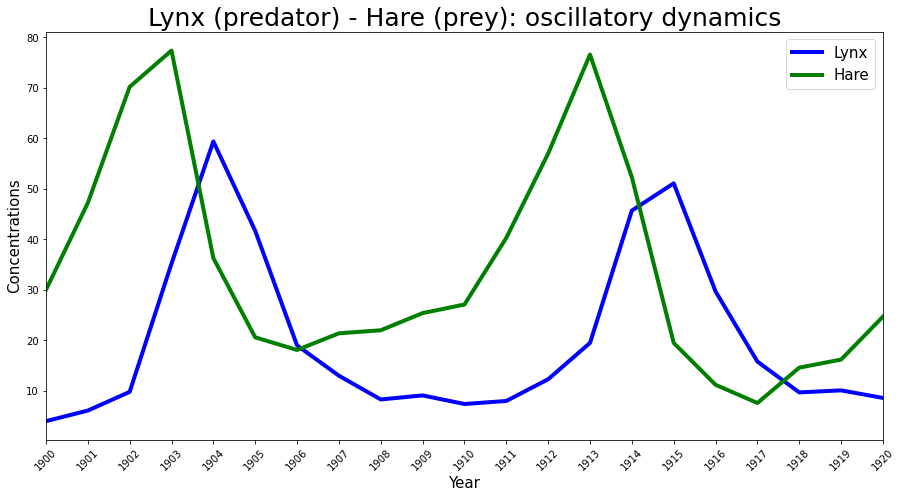

In [7]:
Year = np.arange(1900, 1921, 1)
# fmt: off
Lynx = np.array([4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
                8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6])
Hare = np.array([30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4,
                 27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])
# fmt: on
plt.figure(figsize=(15, 7.5))
plt.plot(Year, Lynx, color="b", lw=4, label="Lynx")
plt.plot(Year, Hare, color="g", lw=4, label="Hare")
plt.legend(fontsize=15)
plt.xlim([1900, 1920])
plt.xlabel("Year", fontsize=15)
plt.ylabel("Concentrations", fontsize=15)
plt.xticks(Year, rotation=45)
plt.title("Lynx (predator) - Hare (prey): oscillatory dynamics", fontsize=25);

In [8]:
theano.config.exception_verbosity = "high"
theano.config.floatX = "float64"


# Define the data matrix
Y = np.vstack((Hare, Lynx)).T

# Now instantiate the theano custom ODE op
my_ODEop = ODEop(state, numpy_vsp)

# The probabilistic model
with pm.Model() as LV_model:

    # Priors for unknown model parameters

    alpha = pm.Normal("alpha", mu=1, sigma=0.5)
    beta = pm.Normal("beta", mu=0.05, sigma=0.05)
    gamma = pm.Normal("gamma", mu=1, sigma=0.5)
    delta = pm.Normal("delta", mu=0.05, sigma=0.05)

    xt0 = pm.Lognormal("xto", mu=np.log(10), sigma=1)
    yt0 = pm.Lognormal("yto", mu=np.log(10), sigma=1)
    sigma = pm.Lognormal("sigma", mu=-1, sigma=1, shape=2)

    # Forward model
    all_params = pm.math.stack([alpha, beta, gamma, delta, xt0, yt0], axis=0)
    ode_sol = my_ODEop(all_params)
    forward = ode_sol.reshape(Y.shape)

    # Likelihood
    Y_obs = pm.Lognormal("Y_obs", mu=pm.math.log(forward), sigma=sigma, observed=Y)

    trace = pm.sample(1500, init="jitter+adapt_diag", cores=1)
trace["diverging"].sum()

/tmp/ipykernel_14279/3693050365.py:33: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1500, init="jitter+adapt_diag", cores=1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/alex/anaconda3/envs/ml4t/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Slice: [yto]
>>Slice: [xto]
>>Slice: [delta]
>>Slice: [gamma]
>>Slice: [beta]
>>Slice: [alpha]
>NUTS: [sigma]


SamplingError: Bad initial energy

In [ ]:
with LV_model:
    az.plot_trace(trace);